In [1]:
import os
import sys
import time
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import cv2

from utils import *
import imageio
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
original = cv2.imread('resources/wfc-circuit-1.png')

start = 107
end = 121
tiles = []
idx = 0
for i in range(13):
    tile = Tile(original[start:end, :14, :], idx)
    idx += 1
    start += 16
    end += 16
    tiles.append(tile)

In [3]:
# rotate and flip tiles to augment data
num_tiles = len(tiles)
for i in range(num_tiles):
    tile = tiles[i]
    img = deepcopy(tile.img)
    img90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img180 = cv2.rotate(img, cv2.ROTATE_180)
    img270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if not np.all(img90 == img):
        new_tile = Tile(img90, idx)
        idx += 1
        tiles.append(new_tile)
    if not np.all(img180 == img) and not np.all(img180 == img90):
        new_tile = Tile(img180, idx)
        idx += 1
        tiles.append(new_tile)
    if not np.all(img270 == img) and not np.all(img270 == img90) and not np.all(img270 == img180):
        new_tile = Tile(img270, idx)
        idx += 1
        tiles.append(new_tile)

In [4]:
for i in range(len(tiles)):
    for j in range(i, len(tiles)):
        check_and_add(tiles[i], tiles[j])

In [5]:
# extra rules
for direction in tiles[0].neighbors:
    tiles[0].neighbors[direction].add(0)
    
tiles[19].neighbors['bottom'] = {0}
tiles[18].neighbors['right'] = {0}
tiles[17].neighbors['top'] = {0}
tiles[4].neighbors['left'] = {0}

for i in [5, 20, 21, 22]:
    for direction in tiles[i].neighbors:
        for j in [5, 20, 21, 22]:
            if j in tiles[i].neighbors[direction]:
                tiles[i].neighbors[direction].remove(j)
                
for i in [2, 13, 14, 15]:
    for direction in tiles[i].neighbors:
        for j in [2, 13, 14, 15]:
            if j in tiles[i].neighbors[direction]:
                tiles[i].neighbors[direction].remove(j)

for i in [11, 32, 33, 34]:
    for direction in tiles[i].neighbors:
        for j in [11, 32, 33, 34]:
            if j in tiles[i].neighbors[direction]:
                tiles[i].neighbors[direction].remove(j)
                
for i in [2, 12, 13, 14, 15, 35]:
    for direction in tiles[i].neighbors:
        for j in [2, 12, 13, 14, 15, 35]:
            if j in tiles[i].neighbors[direction]:
                tiles[i].neighbors[direction].remove(j)
                
for i in [10, 11, 31, 32, 33, 34]:
    for direction in tiles[i].neighbors:
        for j in [10, 11, 31, 32, 33, 34]:
            if j in tiles[i].neighbors[direction] and j != i:
                tiles[i].neighbors[direction].remove(j)
                
# tiles[10].neighbors = {
#     'top': {17, 23, 24, 28, 29, 30, 35},
#     'bottom': {9, 15, 19, 23, 24, 26, 28, 30, 35},
#     'left': {2, 4, 6, 7, 9, 12, 27, 28, 29},
#     'right': {6, 7, 9, 12, 14, 18, 25, 29, 30}
# }

In [6]:
tile_idx_list = [x.idx for x in tiles]
for tile in tiles:
    for key in tile.neighbors:
        neighbor_set = tile.neighbors[key]
        tile.exclusions[key] = set(tile_idx_list) - set(neighbor_set)

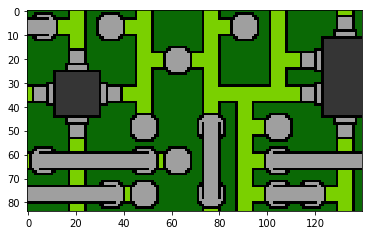

In [7]:
# np.random.seed(2)
rows = 6
cols = 10
history = []
retract = False
num_tiles = len(tiles)
observed = np.zeros(shape = (rows, cols))
canvas = np.zeros(shape = (rows, cols), dtype = int) - 1
entropy_board = np.zeros(shape = (rows, cols)) + num_tiles
choices = {}
for i in range(rows):
    for j in range(cols):
        choices[(i, j)] = np.arange(num_tiles).tolist()

info = dict(
    entropy_board = entropy_board,
    observed = observed,
    choices = choices,
    history = history,
    canvas = canvas,
    tiles = tiles,
    rows = rows,
    cols = cols,
    tile_idx_list = tile_idx_list
)

info_history = []
info_history_full = []

while not np.all(info['observed'] == True):
    info_history.append(deepcopy(info))
    info, retract = step(info)
    info_history_full.append(deepcopy(info))
    
    while retract:
        # undo one step
        last_step = info['history'].pop()
        last_row, last_col, last_choice, valid_choices = last_step
        valid_choices.remove(last_choice)
        if len(valid_choices) > 0:
            info['choices'][(last_row, last_col)] = valid_choices
        else:
            info = info_history.pop()
        info, retract = step(info, (last_row, last_col))
        info_history_full.append(deepcopy(info))
        
    entropy_board = update_entropy(choices, rows, cols)
info_history.append(deepcopy(info))
# display canvas
image = np.zeros(shape = (14*rows, 14*cols, 3))
for row in range(rows):
    for col in range(cols):
        image[row*14:(row+1)*14, col*14:(col+1)*14, :] = tiles[int(info['canvas'][row, col])].img
plt.figure(figsize=(6, 4))
plt.imshow(image/255.0)
np.save('output/history_full.npy', info_history_full)
np.save('output/history.npy', info_history)

In [8]:
len(info_history)

59

In [9]:
len(info_history_full)

371

In [10]:
images = []
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 15
out = cv2.VideoWriter('output/wfc-circuit.mp4', fourcc, fps, (140, 84))
for info in info_history_full:
    image = np.zeros(shape = (14*rows, 14*cols, 3))
    for row in range(rows):
        for col in range(cols):
            idx = int(info['canvas'][row, col])
            if idx == -1:
                idx = 0
            image[row*14:(row+1)*14, col*14:(col+1)*14, :] = tiles[idx].img
    image = image.astype(np.uint8)
    out.write(image)
    images.append(image)
for i in range(2 * fps):
    out.write(image.astype(np.uint8))
    images.append(image)
out.release()
imageio.mimsave('output/wfc-circuit.gif', images)